In [162]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold


In [129]:
#@ READING THE DATASET:
df = pd.read_csv('AER_credit_card_data.csv')
df.columns = df.columns.str.lower().str.replace(' ','_')
df.shape
df.head(10)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
5,yes,0,23.25000,2.5000,0.044438,91.996670,no,no,0,54,1,1
6,yes,0,27.91667,3.9600,0.012576,40.833330,no,no,2,7,1,5
7,yes,0,29.16667,2.3700,0.076434,150.790000,yes,no,0,77,1,3
8,yes,0,37.00000,3.8000,0.245628,777.821700,yes,no,0,97,1,6
9,yes,0,28.41667,3.2000,0.019780,52.580000,no,no,0,65,1,18


In [130]:
#@ CREATING THE TARGET VARIABLE:
df.card = df.card.map(dict(yes=1, no=0))
df.head(10)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
5,1,0,23.25000,2.5000,0.044438,91.996670,no,no,0,54,1,1
6,1,0,27.91667,3.9600,0.012576,40.833330,no,no,2,7,1,5
7,1,0,29.16667,2.3700,0.076434,150.790000,yes,no,0,77,1,3
8,1,0,37.00000,3.8000,0.245628,777.821700,yes,no,0,97,1,6
9,1,0,28.41667,3.2000,0.019780,52.580000,no,no,0,65,1,18


In [147]:
df.dtypes
numerical = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active"]
categorical = ["owner", "selfemp"]



In [148]:
#@ SPLITTING THE DATASET:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card
y_val = df_val.card
y_test = df_test.card

del df_train['card']
del df_val['card']
del df_test['card']

In [149]:
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print(c, '%.3f' %auc)
        
    

reports 0.717
age 0.524
income 0.591
share 0.989
expenditure 0.991
dependents 0.533
months 0.529
majorcards 0.534
active 0.604


In [152]:
len(df[df.card==1])/len(df)

0.775587566338135

In [153]:
#@ TRAINING LOGISTIC REGRESSION MODEL:
train_cols = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
dv = DictVectorizer(sparse=False)

train_dicts = df_train[train_cols].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train,y_train)

val_dicts = df_val[train_cols].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]



In [154]:
roc_auc_score(y_val, y_pred).round(3)

0.995

In [156]:
#@ PRECISION AND RECALL

def conf_matrix(y_val, y_pred):
    
    thresholds = np.linspace(0, 1, 101)
    
    scores = []

    for t in thresholds:
        actual_positives = (y_val == 1)
        actual_negatives = (y_val == 0)
        #print(actual_positives,actual_negatives)
        predicted_positives = (y_pred >= t)
        predicted_negatives = (y_pred < t)
        #print(predicted_positives,predicted_negatives)
        tp = (predicted_positives & actual_positives).sum()
        tn = (predicted_negatives & actual_negatives).sum()
        
        fp = (predicted_positives & actual_negatives).sum()
        fn = (predicted_negatives & actual_positives).sum()
        #print((t,tp,fp,fn,tn))
        scores.append((t, tp, fp, fn, tn))
        
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

#@ IMPLEMENTATION OF FUNCTION:
df_scores = conf_matrix(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,211,53,0,0
10,0.1,210,17,1,36
20,0.2,207,5,4,48
30,0.3,205,5,6,48
40,0.4,205,1,6,52
50,0.5,204,1,7,52
60,0.6,204,1,7,52
70,0.7,204,1,7,52
80,0.8,204,1,7,52
90,0.9,204,0,7,53


In [157]:
#@ ADDING THE COLUMNS:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

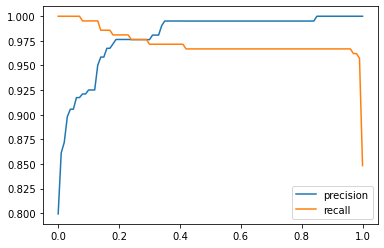

In [158]:
#@ INSPECTING THE CURVES:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()


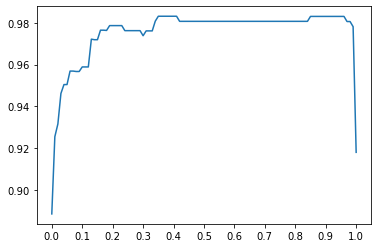

In [161]:
def F1_score(p,r):
    return 2*(p*r)/(p+r)
df_scores['f1'] = F1_score(df_scores['p'],df_scores['r'])
df_scores
#@ INSPECTING F1 SCORE:
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

In [168]:
columns = categorical + numerical

def train(df_train, y_train, C=1.0):
    train_dicts = df_train[columns].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    
    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train,y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred
    
    
    

In [170]:
#@ INITIALIZING KFOLD CROSS VALIDATION:
scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kf.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.card
    y_val = df_val.card
    
    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
print(np.std(scores))
    

0.0027434713804377724


In [180]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kf.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.card
        y_val = df_val.card
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print("C=%4s, %.4f +- %.4f" %(C, np.mean(scores).round(3),np.std(scores).round(3)))

C=0.01, 0.9920 +- 0.0060
C= 0.1, 0.9950 +- 0.0040
C=   1, 0.9960 +- 0.0030
C=  10, 0.9960 +- 0.0030
